In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import math
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

from scipy import stats as st

from dataset import SCIData, SCICols
%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling, dataset

In [2]:
# sci = SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_all().save()
sci = SCIData.quickload("data/sci_processed.h5")
sci = sci[sci.c_NEWS_score.notna()]


## Analysis Functions

### AUROC

We use the AUROC to measure the discriminative ability of NEWS. 

The minimum possible AUROC value, 0.5, corresponds to a completely random relationship between the measured score and adverse outcomes. Generally, a score of 0.7-0.8 indicates reasonable discrimination and values over 0.8 indicate good discrimination.

For large samples, the distribution of AUC is approximately normal. Hence, confidence intervals may be computed using the standard normal distribution as:

\begin{equation}
AUC \pm z_{\alpha/2}SE(AUC)
\end{equation}

The formula for $SE(AUC)$ is:

\begin{equation}
SE(AUC) = \sqrt{\frac{AUC(1-AUC) + (N_1-1)(Q_1-AUC^2) + (N_2-1)(Q_2-AUC^2)}{N_1N_2}}
\end{equation}
where,

\begin{equation}
Q_1 = \frac{AUC}{2-AUC}, \;
Q_2 = \frac{2AUC^2}{1+AUC}
\end{equation}

[Source 1](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_the_Area_Under_an_ROC_Curve.pdf), [Source 2](https://stackoverflow.com/a/50437392/7662085)

In [3]:
def roc_auc_ci(y_true, y_score):
    """ Computes AUROC with 95% confidence intervals
    Uses the formula from 
    :param y_true: True labels or binary label indicators
    :param y_score: Target scores
    """

    # See https://stackoverflow.com/a/20864883/7662085
    # zscore inside of which 95% of data lies
    za2 = st.norm.ppf(0.975)

    # From: https://gist.github.com/doraneko94/e24643136cfb8baf03ef8a314ab9615c
    AUC = metrics.roc_auc_score(y_true, y_score)
    N1, N2 = sum(y_true == True), sum(y_true != True)
    Q1, Q2 = AUC / (2 - AUC), 2 * AUC ** 2 / (1 + AUC)
    SE_AUC = math.sqrt(
        (AUC * (1 - AUC) + (N1 - 1) * (Q1 - AUC ** 2) + (N2 - 1) * (Q2 - AUC ** 2))
        / (N1 * N2)
    )
    lower, upper = max(AUC - za2 * SE_AUC, 0), min(AUC + za2 * SE_AUC, 1)
    return lower, AUC, upper


In [4]:
def multiplot_news_roc(plots, ci=True, save=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for idx, (title, (curves, y_score)) in enumerate(plots.items()):
        for (name, y_true) in curves.items():
            mask = y_true.notna()
            metrics.RocCurveDisplay.from_predictions(
                y_true[mask], y_score[mask], ax=ax[idx], name=name
            )
            if ci:
                lower, auc, upper = roc_auc_ci(y_true, y_score)
                print(
                    f"AUC {name} {title}: {round(auc,3)} ({round(lower, 3)}-{round(upper, 3)})"
                )
        ax[idx].set_title(title)
    if save:
        plt.savefig(save, bbox_inches="tight")


def multiplot_news_roc_with_masks(
    df, masks, columns, score_col="c_NEWS_score", save=None, ci=False
):
    plots = {
        title: (
            {name: df[mask][col] for name, col in columns.items()},
            df[mask][score_col],
        )
        for title, mask in masks.items()
    }
    multiplot_news_roc(plots, ci, save)


def multiplot_news_roc_by_series(
    df, series, score_col="c_NEWS_score", save=None, ci=True
):
    plots = {title: ({"": ser}, df[score_col]) for title, ser in series.items()}
    multiplot_news_roc(plots, ci, save)


### Chi-square Test
Tests the association between categorical variables.
 -  $H_0$: The null hypothesis asserts the independence of the variables under consideration (so, for example, high NEWS and mortality are independent of each other).
 - The null hypothesis is rejected if the P value is less than a level of significance which has been defined in advance. For example, 0.05 for 95% confidence.

The expected frequencies are calculated under the assumption of independence and the degrees of freedom depend on the number of rows and columns of the contingency table we form (`chi2_contingency` does this for us).

In [5]:
def chisquarebinary(col1, col2, mask=None, condense_output=False):
    if mask is not None:
        col1, col2 = col1[mask], col2[mask]
        n = mask.sum()
    else:
        n = col1.shape[0]
    table = np.array(
        [
            [(col1 & col2).sum(), ((~col1) & col2).sum()],
            [(col1 & (~col2)).sum(), (~(col1 | col2)).sum()],
        ]
    )

    chi2, p, dof, expected = st.chi2_contingency(table)
    if condense_output:
        print(f"χ^2 ({dof}, N={n}) = {chi2:.5g}, p={p}")
    else:
        print("Table of counts:")
        display(
            pd.DataFrame(
                table,
                columns=[str(col1.name), "Not " + str(col1.name)],
                index=[str(col2.name), "Not " + str(col2.name)],
            )
        )
        print(f"N = {n}")
        print(f"χ2 statistic:     {chi2:.5g}")
        print(f"p-value:            {p}")
        print(f"Degrees of freedom: {dof}")
        print("Expected frequencies:")
        print(expected)


### Distribution Tests

For a given binary outcome, we compare the sub-populations where it does and does not occur. Specifically, we test the distributions of the following variables:
 - Age
 - NEWS score
 - Total LOS
 - NEWS components

We compare normally distributed variables with Welch's unequal variances t-test, a variant of the Student's t-test that does not assume the populations have equal variances. We compare non-normally distributed variables with Mann-Whitney U test.

In [6]:
def stats_tests_on_outcome(df, col, mask=True, news_components=True, tex=False):
    welch = ("Welch", lambda a, b: st.ttest_ind(a, b, equal_var=False))
    mann = ("Mann", st.mannwhitneyu)
    ind = ("Independent samples", st.ttest_ind)
    tests = {
        "Age": welch,
        "c_NEWS_score": mann,
        "TotalLOS": mann,
    }
    if news_components:
        tests = {
            **tests,
            **{
                component: welch
                for component in SCICols.news_data_raw[:-2]  # Exclude binary components
            },
        }
    results = []
    delim = "\pm" if tex else "±"
    numeric = "$" if tex else ""
    for feature, (testname, test) in tests.items():
        feature_mask = df[feature].notna() & mask
        d1, d2 = df[feature_mask & df[col]], df[feature_mask & ~df[col]]
        t, p = test(d1[feature], d2[feature])
        if tex and feature == "c_NEWS_score":
            featurename = "NEWS"
        else:
            featurename = feature
        results.append(
            (
                featurename,
                feature_mask.sum(),
                f"{numeric}{round(d1[feature].mean(), 2)} {delim} {round(d1[feature].std(), 2)}{numeric}",
                f"{numeric}{round(d2[feature].mean(), 2)} {delim} {round(d2[feature].std(), 2)}{numeric}",
                testname,
                numeric + str(round(t, 6)) + numeric,
                numeric + str(round(p, 6)) + numeric,
            )
        )

    return pd.DataFrame(
        results,
        columns=[
            "Variable",
            "n",
            "Mean (Event)" if tex else "Mean True",
            "Mean ($\lnot$Event)" if tex else "Mean False",
            "Test",
            "Statistic",
            "$p$" if tex else "P value",
        ],
    )


In [7]:
def stats_latex(df, col, thresholds, news_components=True):
    col_order = [
        "Variable",
        "LOS",
        "Mean (Event)",
        "Mean ($\lnot$Event)",
        "Test",
        "$p$",
    ]
    dfs = []
    for threshold, mask in thresholds.items():
        newdf = stats_tests_on_outcome(
            df, col, mask, news_components=news_components, tex=True
        )
        newdf["LOS"] = threshold
        dfs.append(newdf)

    r = pd.concat(dfs)[col_order].set_index(["Variable", "LOS"]).sort_index()

    return r


## Data Summary

Of the 170833 patient records we have, 124162 have the NEWS score (recorded on-admission or by us) and all the component values.

In the records with NEWS:
 - There are 63450 unique patients.
 - There are 65096 (52.43%) female records.
 - There are 5308 (4.28%) deaths during stay and 4086 (3.29%) deaths within 30 days.
 - There are 15836 (12.75%) readmissions within 30 days.
 - 91.43% are admitted through Emergency A&E.
 - 66.48% are admitted into the EAU and 29.43% receive AEC.

In [8]:
def summarise(df, mask, col):
    n = df[mask][col].value_counts()
    props = (n / mask.sum() * 100).round(2).rename("Proportion")
    display(pd.concat([n.rename("n"), props], axis=1))
    return n, props


def summarise_highnews(df, masks):
    high_news = df.c_NEWS_score >= 7
    print("Proportion of occurrences with NEWS >= 7:")
    for key, mask in masks.items():
        n_true, n_total = (mask & high_news).sum(), (mask).sum()
        print(f"{key}: {n_true}/{n_total} = {round(n_true/n_total*100, 2)}%")



In [10]:
mask = (
    sci[SCICols.news_data_raw + ["c_NEWS_score"] + SCICols.news_data_scored]
    .notna()
    .all(axis=1)
)
print(f"Patients with all NEWS data: {mask.sum()}")
print(f"Unique patients (with all NEWS): {sci[mask].PatientNumber.unique().shape[0]}")

n = sci[mask].Female.sum()
print(f"Proportion of female patients: {n} = {round(n/mask.sum()*100, 2)}%")

print("Readmissions:")
_ = summarise(sci, mask, "Readmitted")



Patients with all NEWS data: 124162
Unique patients (with all NEWS): 63450
Proportion of female patients: 65096 = 52.43%
Readmissions:


,n,Proportion
False,49099,39.54
True,15836,12.75


In [11]:
n, props = summarise(sci, mask, "AdmissionMethodDescription")
print(f"Everything except top-2: {n.tail(8).sum()} = {props.tail(8).sum()}")



,n,Proportion
EMERGENCY A+E,113518,91.43
EMERGENCY GP REFER,5955,4.80
BOOKED ADMISSION,1814,1.46
NON EM TRAN OTH PROV,1192,0.96
EMERGENCY OPD,924,0.74
ELECTIVE PLANNED,381,0.31
EMERG TRAN OTH PROV,336,0.27
WAITING LIST,31,0.02
MATERNITY ANTE NATAL,6,0.00
TRAUMA ELECTIVE ADM,5,0.00


Everything except top-2: 4689 = 3.76


In [12]:
n, props = summarise(sci, mask, "AdmitWard")
aec = ["AEC", "AAA", "AAAC"]
print(f"AEC: {n.loc[aec].sum()} = {props.loc[aec].sum()}")



,n,Proportion
EAU,82541,66.48
AEC,18964,15.27
AAA,11012,8.87
AAAC,6570,5.29
HH3,2980,2.40
HH1M,2095,1.69


AEC: 36546 = 29.43


### NEWS Score and Thresholds

The NEWS specification prescribes the level of clinical response depending on the aggregate score the patient receives [RCP17, pp.53, 62]. 
 - Score 0: Low clinical risk, continue routine monitoring.
 - Score 1-4: Low clinical risk, ward-based response, RN assesment of patient.
 - Score of 3 in any single parameter: Low-medium risk, clinician review.
 - Score ≥ 5: Medium clinical risk, urgent response threshold, urgent clinician assessment.
 - Score ≥ 7: High clinical risk, emergency response threshold, urgent assessment, consider transfer to higher-dependency unit or ICU.

In [15]:
_ = summarise(SCIData(sci).derive_news_risk(), mask, "c_NEWS_risk")



,n,Proportion
Low,118081,95.10
Medium,3748,3.02
High,2333,1.88


In [16]:
print(f"Median NEWS: {sci[mask].c_NEWS_score.median()}")
print(
    f"NEWS IQR: {sci[mask].c_NEWS_score.quantile(0.75) - sci[mask].c_NEWS_score.quantile(0.25)}"
)



Median NEWS: 1.0
NEWS IQR: 2.0


## Critical Events

The original study measured ROCAUC based on whether patients that died within 24 hours triggered a red-level score [RCP12, pp. 15-16].
We consider "critical events" i.e. death during stay OR critical care admission.

In [19]:
sci = (
    SCIData(sci)
    .derive_death_within(within=1, col_name="DiedWithin24h")
    .derive_death_within(within=2, col_name="DiedWithin48h")
    .derive_critical_care(within=999, col_name="CriticalCare")
    .derive_critical_care(within=1, col_name="CriticalCareWithin24h")
    .derive_critical_care(within=2, col_name="CriticalCareWithin48h")
)
sci["CriticalEvent"], sci["CriticalEventWithin24h"], sci["CriticalEventWithin48h"] = (
    sci.DiedDuringStay | sci.CriticalCare,
    sci.DiedWithin24h | sci.CriticalCareWithin24h,
    sci.DiedWithin48h | sci.CriticalCareWithin48h,
)
print(f"Total critical events: {sci.CriticalEvent.sum()}")
print(f"Critical events 24h: {sci.CriticalEventWithin24h.sum()}")
print(f"Critical events 48h: {sci.CriticalEventWithin48h.sum()}")
print(f"Critical events with NEWS: {sci[sci.c_NEWS_score.notna()].CriticalEvent.sum()}")



Total critical events: 8826
Critical events 24h: 909
Critical events 48h: 2020
Critical events with NEWS: 8826


In [20]:
summarise_highnews(
    sci,
    {
        "24h": sci.CriticalEventWithin24h,
        "48h": sci.CriticalEventWithin48h,
        "Any": sci.CriticalEvent,
    },
)



Proportion of occurrences with NEWS >= 7:
24h: 300/909 = 33.0%
48h: 550/2020 = 27.23%
Any: 1423/8826 = 16.12%


### AUROC
As a proxy for measurements taken within 24 or 48 hours of a critical event occurring, since we only have admission values, we check stays that lasted a total of n hours altogether.

We check the discriminative ability of NEWS on stays that lasted 24 or 48 hours, and on the full dataset (that has NEWS). 

AUC Within 24h Critical Event: 0.817 (0.8-0.833)
AUC Within 48h Critical Event: 0.807 (0.796-0.819)
AUC At any point Critical Event: 0.769 (0.763-0.775)
AUC Within 24h Mortality: 0.93 (0.911-0.948)
AUC Within 48h Mortality: 0.912 (0.899-0.926)
AUC At any point Mortality: 0.77 (0.762-0.777)
AUC Within 24h Critical Care: 0.759 (0.736-0.781)
AUC Within 48h Critical Care: 0.756 (0.741-0.771)
AUC At any point Critical Care: 0.767 (0.758-0.775)


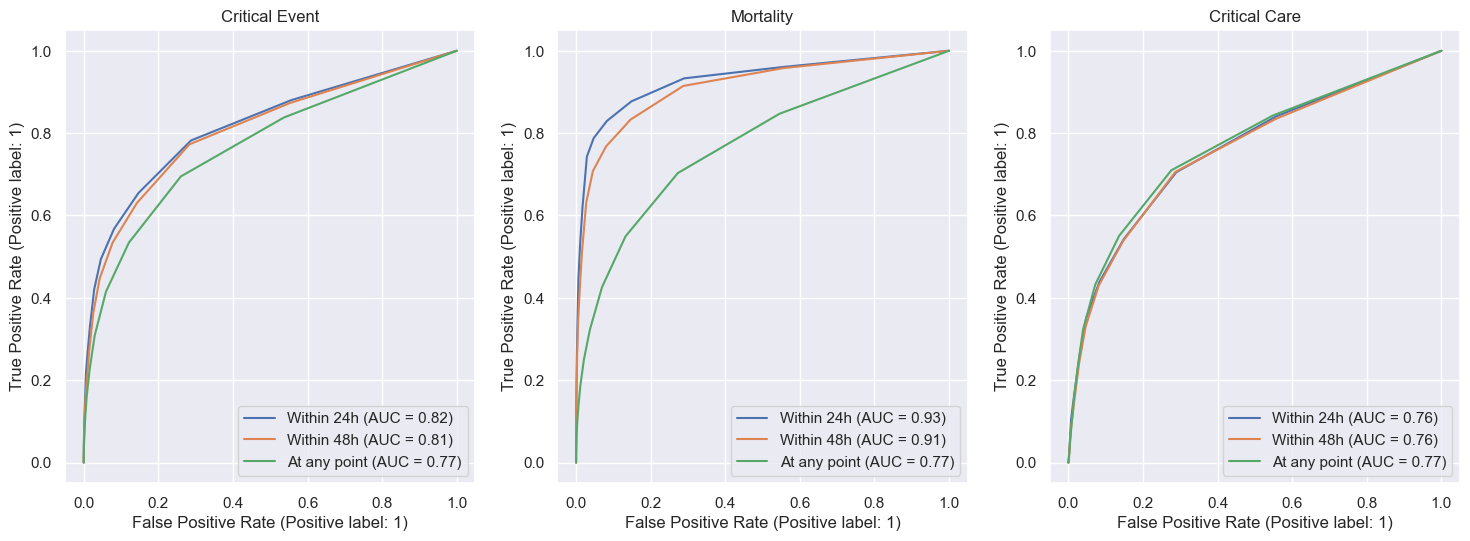

In [21]:
plots = {
    "Critical Event": (
        {
            "Within 24h": sci.CriticalEventWithin24h,
            "Within 48h": sci.CriticalEventWithin48h,
            "At any point": sci.CriticalEvent,
        },
        sci.c_NEWS_score,
    ),
    "Mortality": (
        {
            "Within 24h": sci.DiedWithin24h,
            "Within 48h": sci.DiedWithin48h,
            "At any point": sci.DiedDuringStay,
        },
        sci.c_NEWS_score,
    ),
    "Critical Care": (
        {
            "Within 24h": sci.CriticalCareWithin24h,
            "Within 48h": sci.CriticalCareWithin48h,
            "At any point": sci.CriticalCare,
        },
        sci.c_NEWS_score,
    ),
}


multiplot_news_roc(plots, ci=True, save="images/critical_roc_multi.png")



### Threshold

In [50]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    fbeta_score,
    make_scorer,
)

f2_score = make_scorer(fbeta_score, beta=2)

def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "F2 Score": fbeta_score(y_true, y_pred, beta=2),
    }

In [59]:
mask = sci.c_NEWS_score.notna()
y_pred = sci.c_NEWS_score >= 7
pd.DataFrame([{'Outcome':col, **get_metrics(sci[mask][col], y_pred[mask])} for col in ['CriticalEvent', 'CriticalEventWithin24h', 'CriticalEventWithin48h']]).set_index('Outcome')

,Accuracy,Precision,Recall,F1 Score,F2 Score
Outcome,,,,,
CriticalEvent,0.932968,0.604246,0.161228,0.254539,0.188932
CriticalEventWithin24h,0.978575,0.127389,0.330033,0.183824,0.250376
CriticalEventWithin48h,0.973662,0.233546,0.272277,0.251429,0.263536


### Chi-square

We perform a chi-square test of independence to examine the relation between critical event occurrence and high-clinical risk per the NEWS. The relation between these variables was significant in all cases.

In [22]:
# 24 hours, 48 hours, all
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalEventWithin24h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalEventWithin48h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalEvent, condense_output=True,
)



χ^2 (1, N=124343) = 4752.6, p=0.0
χ^2 (1, N=124343) = 7078.6, p=0.0
χ^2 (1, N=124343) = 10344, p=0.0


In total, 1423/8826 (16%) of critical event occurrences had NEWS >= 7

In [23]:
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalEvent, condense_output=False,
)



Table of counts:


,c_NEWS_score,Not c_NEWS_score
CriticalEvent,1423,7403
Not CriticalEvent,932,114585


N = 124343
χ2 statistic:     10344
p-value:            0.0
Degrees of freedom: 1
Expected frequencies:
[[   167.16043525   8658.83956475]
 [  2187.83956475 113329.16043525]]


### Population Comparison

Patients who experienced critical events were older (71.72 ± 16.85 years; Welch's unequal variances t-test p < 0.0001) and had higher NEWS (3.51 ± 3.1; Mann-Whitney U test p < 0.0001) compared to patients who did not (mean age 64.5 ± 20.62 years; NEWS 1.04 ± 1.4). 

The mean total LOS was 16.32 ± 24.25 for patients who experiences critical events and 6.07 ± 13.62 for those who did not (Mann-Whitney U test p < 0.0001).

In [24]:
stats_tests_on_outcome(sci, "CriticalEventWithin24h", news_components=False)



,Variable,n,Mean True,Mean False,Test,Statistic,P value
0,Age,124343,66.12 ± 19.0,65.0 ± 20.47,Welch,1.772548,0.076633
1,c_NEWS_score,124343,5.11 ± 4.08,1.19 ± 1.64,Mann,91619934.5,0.0
2,TotalLOS,124343,6.26 ± 11.77,6.8 ± 14.89,Mann,54052722.0,0.057513


In [25]:
stats_tests_on_outcome(sci, "CriticalEventWithin48h", news_components=False)


,Variable,n,Mean True,Mean False,Test,Statistic,P value
0,Age,124343,66.5 ± 18.81,64.98 ± 20.48,Welch,3.598662,0.000327
1,c_NEWS_score,124343,4.61 ± 3.76,1.16 ± 1.59,Mann,199472340.0,0.0
2,TotalLOS,124343,6.38 ± 10.76,6.81 ± 14.92,Mann,133423754.5,0.0


In [26]:
stats_tests_on_outcome(sci, "CriticalEvent", news_components=False)



,Variable,n,Mean True,Mean False,Test,Statistic,P value
0,Age,124343,71.72 ± 16.85,64.5 ± 20.62,Welch,38.170609,0.0
1,c_NEWS_score,124343,3.51 ± 3.1,1.04 ± 1.4,Mann,784214337.5,0.0
2,TotalLOS,124343,16.32 ± 24.25,6.07 ± 13.62,Mann,784876248.5,0.0


### Mortality

In [27]:
summarise_highnews(
    sci,
    {"24h": sci.DiedWithin24h, "48h": sci.DiedWithin48h, "Any": sci.DiedDuringStay,},
)



Proportion of occurrences with NEWS >= 7:
24h: 222/358 = 62.01%
48h: 401/784 = 51.15%
Any: 995/5328 = 18.67%


In [28]:
# 24 hours, 48 hours, all
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.DiedWithin24h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.DiedWithin48h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.DiedDuringStay, condense_output=True,
)



χ^2 (1, N=124343) = 6951, p=0.0
χ^2 (1, N=124343) = 10274, p=0.0
χ^2 (1, N=124343) = 8426.9, p=0.0


### Critical Care

In [29]:
summarise_highnews(
    sci,
    {
        "24h": sci.CriticalCareWithin24h,
        "48h": sci.CriticalCareWithin48h,
        "Any": sci.CriticalCare,
    },
)



Proportion of occurrences with NEWS >= 7:
24h: 109/597 = 18.26%
48h: 219/1353 = 16.19%
Any: 662/4384 = 15.1%


In [30]:
# 24 hours, 48 hours, all
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalCareWithin24h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalCareWithin48h, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.CriticalCare, condense_output=True,
)



χ^2 (1, N=124343) = 855.7, p=4.192603293193232e-188
χ^2 (1, N=124343) = 1496, p=0.0
χ^2 (1, N=124343) = 4258.1, p=0.0


## Readmission

In [31]:
summarise_highnews(
    sci,
    {
        "2 days": sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=2)),
        "7 days": sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=7)),
        "30 days": sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=30)),
    },
)



Proportion of occurrences with NEWS >= 7:
2 days: 21/1462 = 1.44%
7 days: 43/4546 = 0.95%
30 days: 196/15859 = 1.24%


AUC  Readmission within 2 days: 0.489 (0.474-0.503)
AUC  Readmission within 7 days: 0.485 (0.477-0.494)
AUC  Readmission within 30 days: 0.52 (0.515-0.525)


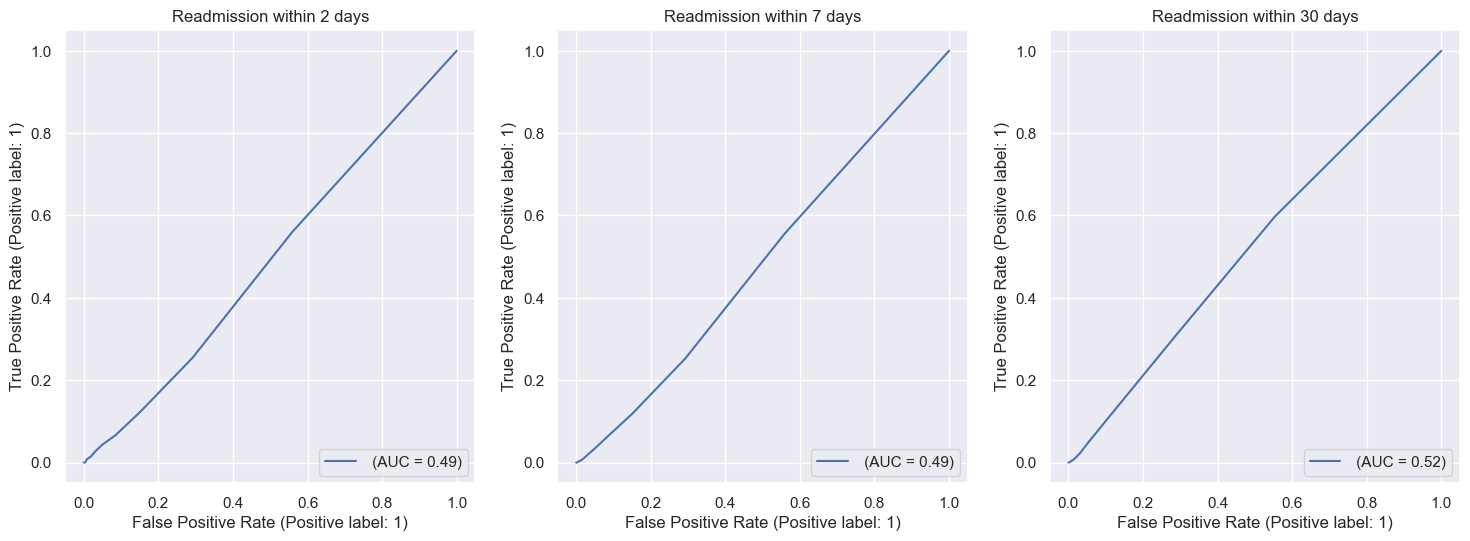

In [32]:
multiplot_news_roc_by_series(
    sci,
    {
        "Readmission within 2 days": sci.Readmitted
        & (sci.ReadmittedTimespan <= pd.Timedelta(days=2)),
        "Readmission within 7 days": sci.Readmitted
        & (sci.ReadmittedTimespan <= pd.Timedelta(days=7)),
        "Readmission within 30 days": sci.Readmitted
        & (sci.ReadmittedTimespan <= pd.Timedelta(days=30)),
    },
)


In [33]:
# 24 hours, 48 hours, all
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=2)),
    sci.Readmitted.notna(),
    condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=7)),
    sci.Readmitted.notna(),
    condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.Readmitted & (sci.ReadmittedTimespan <= pd.Timedelta(days=30)),
    sci.Readmitted.notna(),
    condense_output=True,
)



χ^2 (1, N=65015) = 0.43611, p=0.509005634883033
χ^2 (1, N=65015) = 2.7151, p=0.09940398264140986
χ^2 (1, N=65015) = 0.054341, p=0.8156752669942511


## LOS

In [34]:
summarise_highnews(
    sci,
    {
        "24h": (sci.TotalLOS >= 1),
        "48h": (sci.TotalLOS >= 2),
        "7 days": (sci.TotalLOS >= 7),
    },
)



Proportion of occurrences with NEWS >= 7:
24h: 2037/81488 = 2.5%
48h: 1786/65600 = 2.72%
7 days: 1030/31702 = 3.25%


AUC  LOS over 24h: 0.602 (0.598-0.605)
AUC  LOS over 48h: 0.607 (0.604-0.61)
AUC  LOS over 7 days: 0.598 (0.594-0.602)


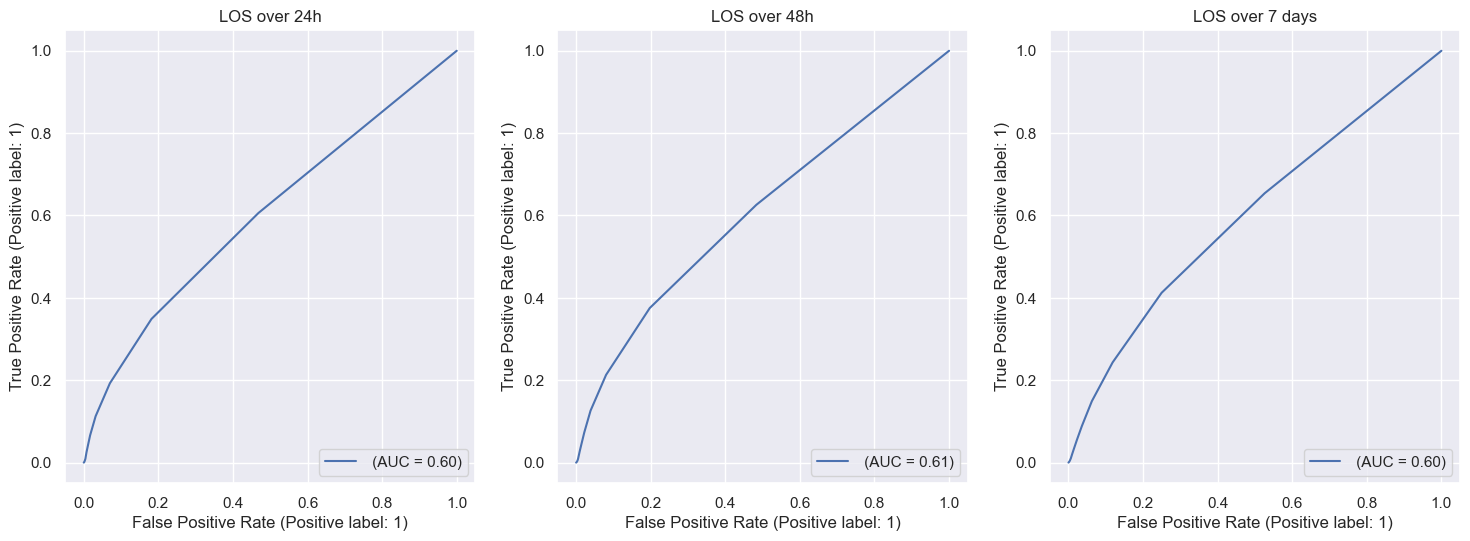

In [35]:
multiplot_news_roc_by_series(
    sci,
    {
        "LOS over 24h": sci.TotalLOS >= 1,
        "LOS over 48h": sci.TotalLOS >= 2,
        "LOS over 7 days": sci.TotalLOS >= 7,
    },
    save="images/los_roc.png",
)



In [36]:
# 24 hours, 48 hours, 7 days
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.TotalLOS >= 1, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.TotalLOS >= 2, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7), sci.TotalLOS >= 7, condense_output=True,
)


χ^2 (1, N=124343) = 466.04, p=2.3267505029193576e-103
χ^2 (1, N=124343) = 512.15, p=2.155186902219107e-113
χ^2 (1, N=124343) = 419.51, p=3.123686572067687e-93


In [37]:
# 24 hours, 48 hours, 7 days
chisquarebinary(
    (sci.c_NEWS_score >= 5), sci.TotalLOS >= 1, sci.TotalLOS > 0, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 5), sci.TotalLOS >= 2, sci.TotalLOS > 0, condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 5), sci.TotalLOS >= 7, sci.TotalLOS > 0, condense_output=True,
)


χ^2 (1, N=124343) = 1440.1, p=0.0
χ^2 (1, N=124343) = 1751.4, p=0.0
χ^2 (1, N=124343) = 1387, p=1.3948104943917297e-303


In [38]:
mask = sci.TotalLOS > 0
st.spearmanr(sci[mask].c_NEWS_score, sci[mask].TotalLOS)


SpearmanrResult(correlation=0.2105968423291092, pvalue=0.0)

In [39]:
print(
    f"Median length of stay for scores under 7: {sci[(sci.c_NEWS_score < 7) & mask].TotalLOS.median()}"
)
print(
    f"Median length of stay for scores >= 7: {sci[(sci.c_NEWS_score >= 7) & mask].TotalLOS.median()}"
)


Median length of stay for scores under 7: 2.20625
Median length of stay for scores >= 7: 5.8972222


## 30-Day Mortality

In [40]:
summarise_highnews(
    sci,
    {
        "24h": (sci.TotalLOS <= 1) & sci.DiedWithin30Days,
        "48h": (sci.TotalLOS <= 2) & sci.DiedWithin30Days,
        "Any": sci.DiedWithin30Days,
    },
)



Proportion of occurrences with NEWS >= 7:
24h: 17/462 = 3.68%
48h: 29/768 = 3.78%
Any: 175/4090 = 4.28%


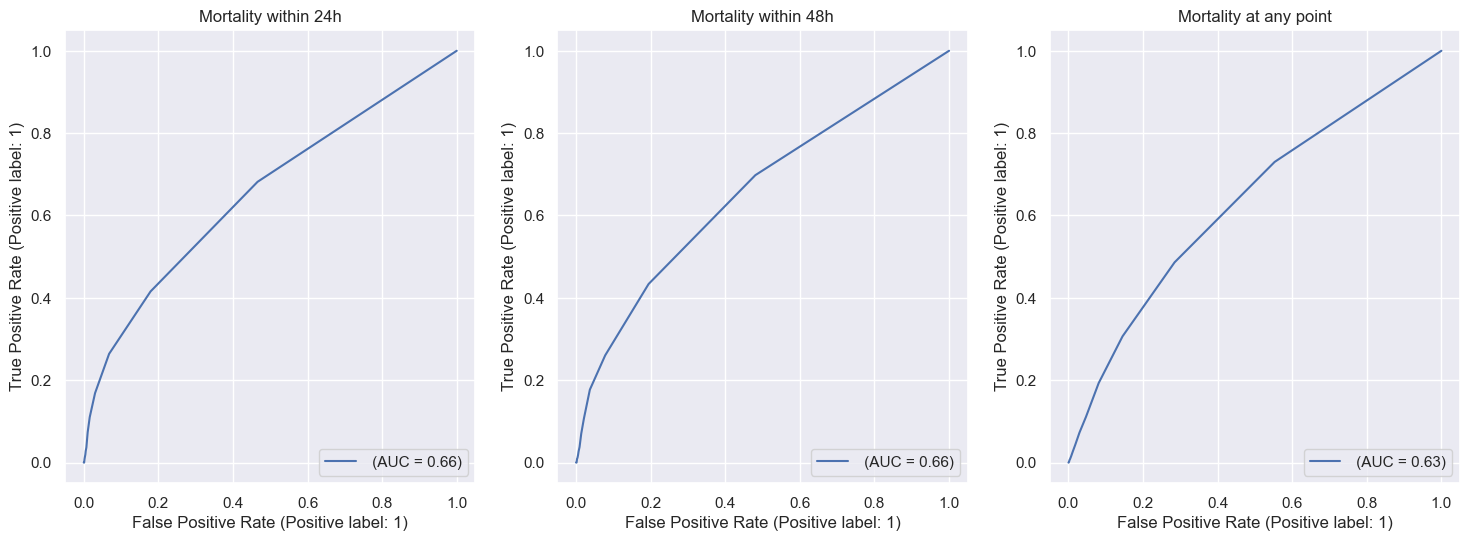

In [41]:
multiplot_news_roc_with_masks(
    sci,
    {
        "Mortality within 24h": (sci.TotalLOS <= 1),
        "Mortality within 48h": (sci.TotalLOS <= 2),
        "Mortality at any point": sci.TotalLOS > 0,
    },
    {'':"DiedWithin30Days"},
    save="images/30daymortality_roc.png",
)



In [42]:
# 24 hours, 48 hours, all
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.DiedWithin30Days,
    (sci.TotalLOS <= 1),
    condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.DiedWithin30Days,
    (sci.TotalLOS <= 2),
    condense_output=True,
)
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.DiedWithin30Days,
    sci.TotalLOS > 0,
    condense_output=True,
)



χ^2 (1, N=42873) = 50.553, p=1.1597230706808926e-12
χ^2 (1, N=58760) = 61.037, p=5.601400838086637e-15
χ^2 (1, N=124343) = 128.12, p=1.0570706182393802e-29


In [43]:
chisquarebinary(
    (sci.c_NEWS_score >= 7),
    sci.DiedWithin30Days,
    sci.TotalLOS > 0,
    condense_output=False,
)



Table of counts:


,c_NEWS_score,Not c_NEWS_score
DiedWithin30Days,175,3915
Not DiedWithin30Days,2180,118073


N = 124343
χ2 statistic:     128.12
p-value:            1.0570706182393802e-29
Degrees of freedom: 1
Expected frequencies:
[[7.74627442e+01 4.01253726e+03]
 [2.27753726e+03 1.17975463e+05]]


In [44]:
stats_tests_on_outcome(sci, "DiedWithin30Days", news_components=False)



,Variable,n,Mean True,Mean False,Test,Statistic,P value
0,Age,124343,77.05 ± 13.14,64.6 ± 20.54,Welch,58.236892,0.0
1,c_NEWS_score,124343,2.0 ± 2.11,1.19 ± 1.68,Mann,309388860.5,0.0
2,TotalLOS,124343,13.49 ± 18.99,6.57 ± 14.65,Mann,346774820.5,0.0
